<a href="https://colab.research.google.com/github/lukas-plojhar/Rhomberg-v2/blob/main/Rhomberg_v2_QGIS_to_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
from PIL import Image
import numpy as np
import json
import cv2
from skimage import measure
import os
import shutil

Global settings


In [ ]:
CONTOUR_THRESH    = 150
ROOT              = 'vogis10' # dataset folder name 
DATASET_NAME      = ROOT
GT_FOLDER         = 'gt'
IMAGE_FOLDER      = 'images'

TRAIN_SPLIT       = 0.85
VAL_SPLIT         = 0.10
TEST_SPLIT        = 0.05

# Download dataset and prepare folder structure

New dataset

In [ ]:
!unzip /content/drive/MyDrive/vogis_2717samples.zip -d vogis2717

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -o /content/drive/MyDrive/vogis_10_images.zip -d vogis10_images
!unzip -o /content/drive/MyDrive/vogis_10_masks.zip -d vogis10_masks

# !mkdir /content/$DATASET_NAME
# !mkdir /content/$DATASET_NAME/dataset
# !mkdir /content/$DATASET_NAME/dataset/images
# !mkdir /content/$DATASET_NAME/dataset/gt

Existing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/vogis_8000samples.zip'
!mv '/content/content/vogis_8000samples' '/content/vogis'
!rm -rf '/content/content'

In [ ]:
!rm -rf 'vogis_8000samples.zip'
!rm -rf 'vogis'

# Reorganize folder structure to COCO

In [ ]:
os.makedirs(f'/content/{DATASET_NAME}/dataset/images')
os.makedirs(f'/content/{DATASET_NAME}/dataset/gt')

In [ ]:
for folder_name in [IMAGE_FOLDER, GT_FOLDER]:
  root = os.path.join(ROOT, folder_name)
  counter = 0
  
  # Loop over zoom folders
  for zoom_level_folder in sorted(os.listdir(root)):
    if zoom_level_folder in ['.DS_Store', '.ipynb_checkpoints']:
        continue

    zoom_level_folder = os.path.join(root, zoom_level_folder)

    # Loop over row folders in a zoom folder
    for row_folder in sorted(os.listdir(zoom_level_folder)):
      if row_folder == '.DS_Store':
        continue
      
      row_folder = os.path.join(zoom_level_folder, row_folder)

      # Loop over images in a row folder
      for image_name in sorted(os.listdir(row_folder)):
        image_name = os.path.join(row_folder, image_name)
        counter = counter + 1
        os.rename(image_name, os.path.join(ROOT, 'dataset', folder_name, str(counter)) + '.jpg')
        # print(f"{image_name} --> {os.path.join(ROOT, 'dataset', folder_name, str(counter)) + '.jpg'}")


shutil.rmtree(f'{ROOT}/gt')
shutil.rmtree(f'{ROOT}/images')
os.rename(f'{ROOT}/dataset/gt', f'{ROOT}/gt')
os.rename(f'{ROOT}/dataset/images', f'{ROOT}/images')
shutil.rmtree(f'{ROOT}/dataset')

# Parse annotations and debug

Remove negative samples and re-enumerate samples

In [ ]:
# Evaluate negative sample
def is_negative_sample(filename: str) -> bool:
  """
  Count pixels values, if sum equals zero sample is negative.
  """

  mask = cv2.imread(os.path.join(ROOT, GT_FOLDER, filename))
  result = np.sum(mask)

  if result == 0:
    return True
  else:
    return False

# Remove image and mask
def remove_sample(filename: str) -> None:
  """
  Remove image and mask based on filename
  """

  image_path = os.path.join(ROOT, IMAGE_FOLDER, filename)
  mask_path = os.path.join(ROOT, GT_FOLDER, filename)

  os.remove(image_path)
  os.remove(mask_path)


# 1. Iterate over GTs
for filename in os.listdir(os.path.join(ROOT, 'gt')):
  if filename in ['.DS_Store', '.ipynb_checkpoints']:
    continue

  if is_negative_sample(filename):
    remove_sample(filename)

# 2. Re-enumerate samples to 'x{id}.jpg'
counter = 1
for filename in sorted(os.listdir(os.path.join(ROOT, 'gt'))):
  if filename in ['.DS_Store', '.ipynb_checkpoints']:
    continue

  for folder in [GT_FOLDER, IMAGE_FOLDER]:
    os.rename(
        os.path.join(ROOT, folder, filename), 
        os.path.join(ROOT, folder, f'x{counter}.jpg')
        )
  
  counter += 1

# 3. From 'x{id}.jpg' to '{id}.jpg'
for filename in sorted(os.listdir(os.path.join(ROOT, 'gt'))):
  if filename in ['.DS_Store', '.ipynb_checkpoints']:
    continue

  for folder in [GT_FOLDER, IMAGE_FOLDER]:
    os.rename(
        os.path.join(ROOT, folder, filename), 
        os.path.join(ROOT, folder, f'{filename[1:]}')
        )

Create splits

In [ ]:
len(os.listdir('/content/vogis10/gt'))

0

In [ ]:
import random as rand

def create_split(split_name: str, size: int, samples_path: list) -> None:
  # Sample
  all_samples = os.listdir(samples_path)
  samples = rand.sample(all_samples, size)

  # Create new folders
  os.makedirs(os.path.join(ROOT, split_name, IMAGE_FOLDER))
  os.makedirs(os.path.join(ROOT, split_name, GT_FOLDER))
  
  for sample in samples:
    for folder in [GT_FOLDER, IMAGE_FOLDER]:
      os.rename(
        os.path.join(ROOT, folder, sample), 
        os.path.join(ROOT, split_name, folder, sample)
        )

# 1. Get sizes of subsets
samples_path = os.path.join(ROOT, IMAGE_FOLDER)

samples_count = len(os.listdir(samples_path))
train_samples_count = int(round(samples_count * TRAIN_SPLIT, 0))
val_samples_count = int(round(samples_count * VAL_SPLIT, 0))
test_samples_count = samples_count - train_samples_count - val_samples_count

In [ ]:
# 2. Generate subsets
create_split('train', train_samples_count, samples_path)
create_split('validation', val_samples_count, samples_path)
create_split('test', test_samples_count, samples_path)

os.remove(os.path.join(ROOT, IMAGE_FOLDER))
os.remove(os.path.join(ROOT, GT_FOLDER))

# Debug
train_subset = os.listdir(os.path.join(ROOT, 'train', IMAGE_FOLDER))
val_subset = os.listdir(os.path.join(ROOT, 'validation', IMAGE_FOLDER))
test_subset = os.listdir(os.path.join(ROOT, 'test', IMAGE_FOLDER))

print(train_samples_count, val_samples_count, test_samples_count, sep='\n')
print(len(train_subset), len(val_subset), len(test_subset), sep='\n')

Parse annotations

In [ ]:
SAMPLE_ID               = 1
SAMPLE_MASK_PATH        = os.path.join(ROOT, 'train', GT_FOLDER, f'{str(SAMPLE_ID)}.jpg')
SAMPLE_IMAGE_PATH       = os.path.join(ROOT, 'train', IMAGE_FOLDER, f'{str(SAMPLE_ID)}.jpg')
# SAMPLE_MASK_PATH        = os.path.join('/content/1.jpg')
# SAMPLE_IMAGE_PATH       = os.path.join('/content/image1.jpg')

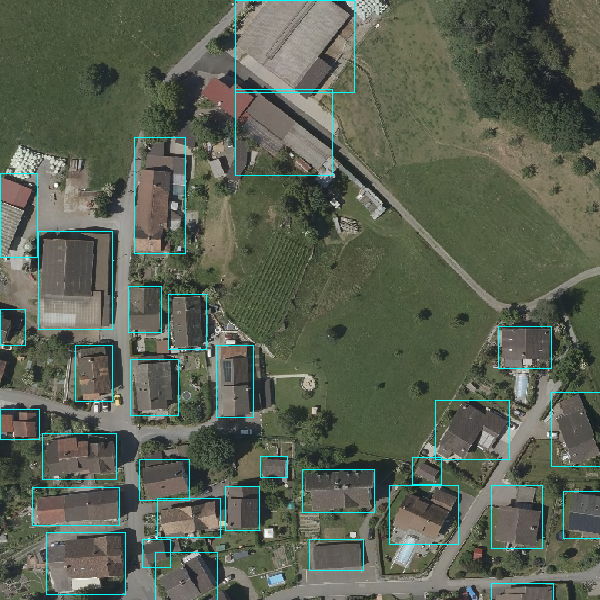

In [ ]:
def get_vectorized_annotations(mask_path: str, mask_tolerance: int = 4) -> tuple:
  """
  Extracts countors from a binary mask to calculate mask polygons and bounding boxes
  """

  mask = cv2.imread(mask_path)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

  contours, hierarchy = cv2.findContours(
      mask.copy(), 
      cv2.RETR_TREE,
      cv2.CHAIN_APPROX_SIMPLE, # cv2.CHAIN_APPROX_NONE
      offset=(0, 0)
  )

  boxes = [np.asarray(cv2.boundingRect(cnt), dtype=float).tolist() for cnt in contours if cv2.contourArea(cnt) > CONTOUR_THRESH]
  masks = [cnt for cnt in contours if cv2.contourArea(cnt) > CONTOUR_THRESH]
  # masks = [cv2.convexHull(cnt) for cnt in contours if cv2.contourArea(cnt) > CONTOUR_THRESH]
  masks = [measure.approximate_polygon(np.squeeze(mask), tolerance = mask_tolerance).tolist() for mask in masks]
  return (boxes, masks)

# ===========================================
# ================ DEBUGGING ================
# ===========================================

def show_masks(image_path: str, masks: list, tolerance: int = 4) -> Image:
  """
  Draws mask polygons on an image
  """
  image = cv2.imread(image_path)

  for mask in masks:
    mask = np.array(mask).flatten().reshape((-1, 1, 2))
    cv2.polylines(image, [mask], isClosed=True, color=(255, 255, 0), thickness=1)

  return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'RGB')


def show_boxes(image_path: str, boxes: list) -> Image:
  """
  Draws bounding boxes on an image
  """

  # cv2.minAreaRect()     highlights the minimum rectangle enclosing a contour (will be rotated)
  # cv2.boxPoints()       obtains the 4 corner points of the obtained rectangle

  image_bb = cv2.imread(image_path)
  [cv2.rectangle(image_bb, (int(box[0]), int(box[1])), (int(box[0])+int(box[2]), int(box[1])+int(box[3])), (255, 255, 0), 1) for box in boxes]

  return Image.fromarray(cv2.cvtColor(image_bb, cv2.COLOR_BGR2RGB), 'RGB')

# Debugging
(boxes, masks) = get_vectorized_annotations(SAMPLE_MASK_PATH, mask_tolerance=4)
show_boxes(SAMPLE_IMAGE_PATH, boxes)
# show_masks(SAMPLE_IMAGE_PATH, masks)

# Parse annotations and files to COCO

In [ ]:
SPLITS        = ['train', 'validation', 'test']
IMAGE_DIR     = os.path.join(ROOT, IMAGE_FOLDER)
MASK_DIR      = os.path.join(ROOT, GT_FOLDER)
OUTPUT_FILE   = os.path.join(ROOT, 'annotations.json')

In [ ]:
def create_image_info(image_id: int, file_name: str, image_size: tuple) -> dict:
  """
  Creates dict with image info for COCO dataset
  """
  return dict(
      id        = image_id,
      file_name = file_name,
      width     = image_size[0],
      height    = image_size[1]
  )


def create_annotation_info(annotation_id: int, image_id: int, image_size: tuple, category_id: int, mask_path: str, mask_tolerance: int) -> dict:
  """
  Creates dict with annotation info for COCO dataset
  """

  def get_polygon_area(p: list) -> float:
    """
    Shoelace algorithm
    https://www.omnicalculator.com/math/irregular-polygon-area
    https://stackoverflow.com/questions/451426/how-do-i-calculate-the-area-of-a-2d-polygon
    """
    segments = zip(p, p[1:] + [p[0]])
    return 0.5 * abs(sum(x0*y1 - x1*y0 for ((x0, y0), (x1, y1)) in segments))

  (boxes, polygons) = get_vectorized_annotations(mask_path, mask_tolerance=mask_tolerance)
  result = list()

  for i, (box, polygon) in enumerate(zip(boxes, polygons)):

    result.append(dict(
        id            = annotation_id + len(result),
        image_id      = image_id,
        category_id   = category_id,
        iscrowd       = 0,
        area          = get_polygon_area(polygon),
        bbox          = box,
        segmentation  = [np.asarray(polygon, dtype=float).flatten().tolist()]
    ))

  return result

def generate_coco_annotations(image_dir: str, mask_dir: str, output_file: str, debug: bool = False) -> None:
  """
  Create COCO-styled annotations from images and masks in a folder
  """

  images = list()
  annotations = list()

  for index, sample in enumerate(os.listdir(image_dir)):
    if sample in ['.DS_Store', '.ipynb_checkpoints']:
      continue

    image_path  = os.path.join(image_dir, sample)
    image_id    = len(images) + 1
    image_size  = Image.open(image_path).size

    annotation_path = os.path.join(mask_dir, sample)
    annotation_id   = len(annotations) + 1
    category_id     = 1

    # Generates dict for image info
    image_info = create_image_info(
        image_id    = image_id,
        file_name   = sample,
        image_size  = image_size
    )

    # Generates dict for annotation info
    annotation_info = create_annotation_info(
        image_id          = image_id,
        image_size        = image_size,
        annotation_id     = annotation_id,
        category_id       = category_id,
        mask_path         = annotation_path,
        mask_tolerance    = 4
    )

    if (len(annotation_info) == 0):
      os.remove(image_path)
      os.remove(annotation_path)
      continue

    images.append(image_info)
    annotations = annotations + annotation_info

  # Generate COCO dict
  output = dict(
      info        = dict(description = 'QGIS dataset test',),
      categories  = [dict(id=1, name='building', supercategory='buildings')],
      images      = images,
      annotations = annotations
  )

  # Debugging
  if debug:
    # print(annotations[5])
    pass
  else:
    with open(os.path.join(output_file), 'w') as f:
      f.write(json.dumps(output))


# 1. Create COCO file
for split in SPLITS:
  image_dir = os.path.join(ROOT, split, IMAGE_FOLDER)
  mask_dir = os.path.join(ROOT, split, GT_FOLDER)
  output_file = os.path.join(ROOT, split, 'annotations.json')

  generate_coco_annotations(image_dir, mask_dir, output_file)

Debug COCO file

In [ ]:
with open(os.path.join(ROOT, 'annotations.json'), 'r') as f:
  coco = json.load(f)

for ann in coco['annotations']:
  print(ann['id'], ann['bbox'], sep=' = ')

# Zip and upload to Google Drive

In [ ]:
!zip -r 'vogis6K.zip' 'vogis10'

In [ ]:
!cp 'vogis6K.zip' 'drive/MyDrive/vogis_6K.zip'